In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import multinomial

The number of beads around a central one goes up as 6 times the radius, because each edge of the hexagon is going up by 1.

In [2]:
from IPython.display import display, Image

img_url = "https://i.stack.imgur.com/lur7D.png"
display(Image(url=img_url, width=250))  # You can adjust the width as needed


In [3]:
def beads_in_ring(radius):
    """
    Returns the number of beads in a ring of a given radius.

    Note that this is hexagonal ring, not a circular ring, so "radius" can't be
    interpreted as an exact euclidean distance.

    Args:
        radius (int): The radius of the ring.

    Returns:
        int: The number of beads in the ring.
    """
    return 6*radius

The beads come in different types, and we only get amplification from compatible beads.

In [4]:
# There are 20 types of beads, and so the probability of a bead being of a given type is 1/20.
PROB_BEADS_COMPATIBLE = 19/20

def compatible_beads_in_ring(radius):
    """The number of beads in a ring that are compatible with the beads in the center.
    This is a radndom variable with a binomial distribution of probability PROB_BEADS_COMPATIBLE.

    Args:
        radius (int): The radius of the ring.

    Returns:
        int: The number of compatible beads in the ring.
    """
    return np.random.binomial(beads_in_ring(radius), PROB_BEADS_COMPATIBLE)

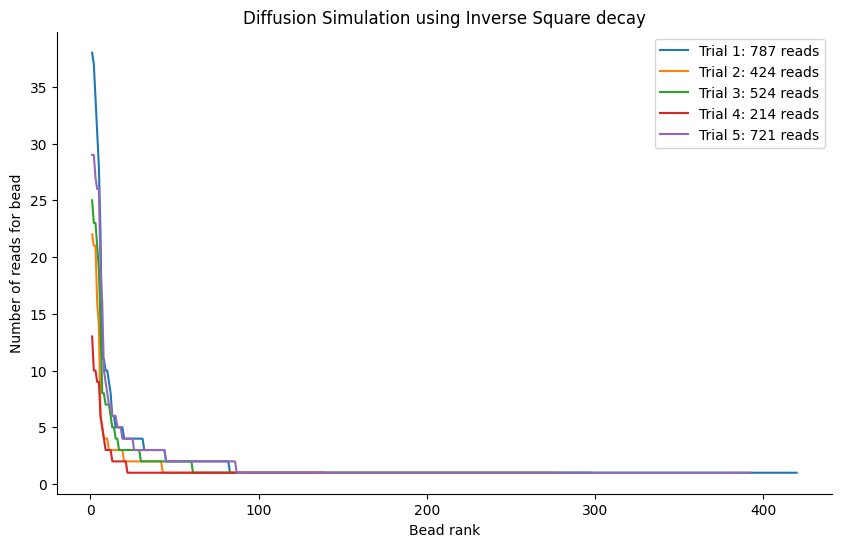

In [5]:
def prepare_array_for_mutinomial(decay_fn, max_radius):
    """Make the array of weights for the multinomial distribution for the number
    of reads from beads in the region around a central bead.

    Args:
        decay_fn (function): A function mapping the radius to the unnormalized
                             probability of getting a read from a bead at that
                             radius.
        max_radius (int): The maximum radius of the region around the central bead.

    Returns:
        np.ndarray: A normalized probability vector.
    """
    weights = [0.0]
    for i in range(1, max_radius):
        weights.extend([decay_fn(i)]*compatible_beads_in_ring(i))
        
    weights_array = np.array(weights)
    weights_array = weights_array/np.sum(weights_array)
    return weights_array


def simulate_diffusion(decay_fn, max_radius, read_count):
    """
    Simulates diffusion of reads on a 2d hexagonal lattice of beads.

    Args:
        decay_fn (function): A function mapping the radius to the unnormalized
                             probability of getting a read from a bead at that
                             radius.
        max_radius (int): The maximum radius of the region around the central bead.
        sample_size (int): The number of reads to simulate.

    Returns:
        np.ndarray: A sorted array of counts of reads per bead.
    """
    
    probs = prepare_array_for_mutinomial(decay_fn, max_radius)
    sample = multinomial.rvs(n=read_count, p=probs)
    # Throw away zero counts and sort in decreasing order.
    sample = np.sort(sample[sample > 0])[::-1]
    return sample
    

def plot_diffusion_simple(decay_fn, decay_name, max_radius, read_count, trials):
    plt.figure(figsize=(10, 6))
    
    max_y_value = 0  # to help set the yticks later
    
    for _ in range(trials):
        results = simulate_diffusion(decay_fn, max_radius, read_count)
        max_y_value = max(max_y_value, max(results))
        
        sns.lineplot(x=range(1, len(results) + 1), y=results, lw=1.5)
    
    plt.xlabel("Read count per bead")
    plt.ylabel("Number of beads")
    plt.title(f"Diffusion Simulation for {trials} trials using {decay_name} decay")
    
    sns.despine()
    plt.show()


def plot_diffusion(decay_fn, decay_name, max_radius, read_count_pdf, trials):
    plt.figure(figsize=(10, 6))
    
    max_y_value = 0  # to help set the yticks later
    
    for trial in range(trials):
        sampled_read_count = read_count_pdf()
        results = simulate_diffusion(decay_fn, max_radius, sampled_read_count)
        max_y_value = max(max_y_value, max(results))
        
        sns.lineplot(x=range(1, len(results) + 1), y=results, lw=1.5, label=f'Trial {trial+1}: {sampled_read_count} reads')
    
    plt.xlabel("Bead rank")
    plt.ylabel("Number of reads for bead")
    plt.title(f"Diffusion Simulation using {decay_name} decay")
    plt.legend(loc='upper right')
    
    sns.despine()
    plt.show()


# Specify a read_count_pdf such that the log of the value is uniformly distributed between the logarithms of 100 and 1000.
def log_uniform_read_count_pdf():
    log_min = np.log(100)
    log_max = np.log(1000)
    return int(np.exp(np.random.uniform(log_min, log_max)))


our_max_radius = 50
decay_fn_inv_square = lambda r: our_max_radius / (r**2) if r != 0 else 1
plot_diffusion(decay_fn_inv_square, "Inverse Square", our_max_radius, log_uniform_read_count_pdf, 5)

The [Rayleigh distribution](https://en.wikipedia.org/wiki/Rayleigh_distribution) gives the magnitude of vectors with Gaussian-distributed components in two dimensions. Its probability density function (PDF) is given by:

$$
f(r;\sigma) = \frac{r}{\sigma^2} e^{-\frac{r^2}{2\sigma^2}}
$$

where $\sigma$ is the scale (or shape) parameter.

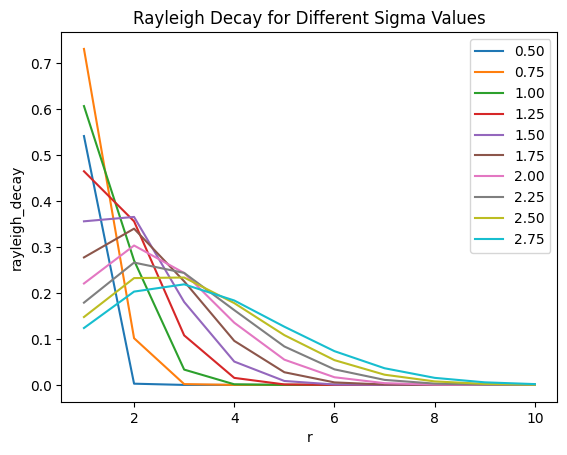

In [6]:
def rayleigh_decay(r, sigma=1):
    """Rayleigh distribution as a decay function."""
    if r < 0:
        return 0
    else:
        return (r / sigma**2) * np.exp(-r**2 / (2 * sigma**2))

# create a range of radii
radii = np.arange(1, 11)

# create a range of sigma values
sigmas = np.arange(0.5, 3.0, 0.25)

# plot rayleigh_decay for each sigma value
for sigma in sigmas:
    values = [rayleigh_decay(r, sigma=sigma) for r in radii]
    plt.plot(radii, values, label=f'{sigma:.2f}') 

# add labels and legend
plt.xlabel('r')
plt.ylabel('rayleigh_decay')
plt.title('Rayleigh Decay for Different Sigma Values')
plt.legend()

# show the plot
plt.show()


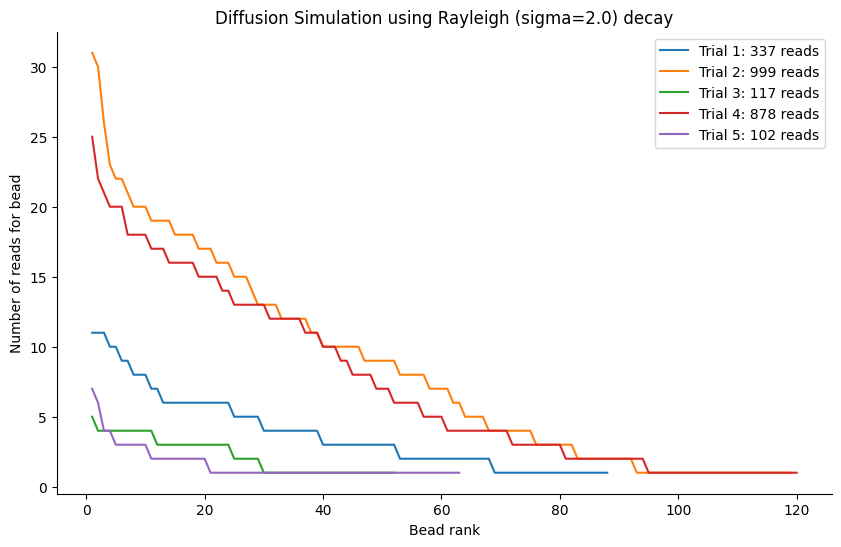

In [7]:
sigma_value = 2.0
decay_fn_rayleigh = lambda r: rayleigh_decay(r, sigma=sigma_value)

plot_diffusion(decay_fn_rayleigh, f"Rayleigh (sigma={sigma_value})", our_max_radius, log_uniform_read_count_pdf, 5)# 

The funny bumps/plateaux that you see above are the result of the Rayleigh distribution essentially being supported on a small number of integers.

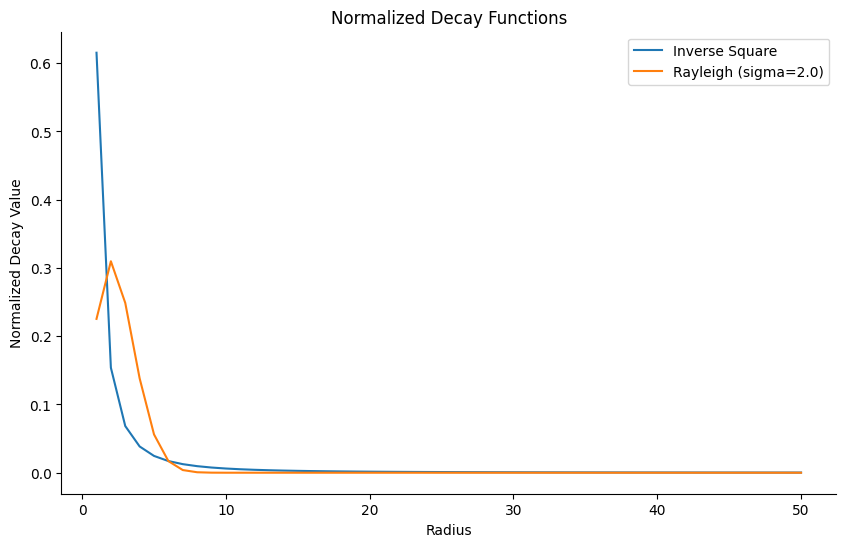

In [8]:
decay_fns = {"Inverse Square": decay_fn_inv_square, f"Rayleigh (sigma={sigma_value})": decay_fn_rayleigh}


# Create a range of radii
radii = range(1, our_max_radius + 1)

plt.figure(figsize=(10, 6))

# Plot each decay function from the dictionary
for name, fn in decay_fns.items():
    values = [fn(r) for r in radii]
    total_value = sum(values)
    normalized_values = [v / total_value for v in values]
    sns.lineplot(x=radii, y=normalized_values, label=name)

plt.xlabel("Radius")
plt.ylabel("Normalized Decay Value")
plt.title("Normalized Decay Functions")
plt.legend()
sns.despine()
plt.show()


It's interesting: the Rayleigh seems to be the "correct" sort of distribution to use, but it doesn't seem to create the shapes of bead distributions I remember seeing in Sanjay's slides. 

The inverse square looks a lot more similar to me.

Let's do this comparison.

In [9]:
twelve_df = pd.read_csv("../data/twelve_samples.csv")
twelve_df

,Index,Column,Value,Rank
0,17590,219,1,166
1,17590,22635,1,165
2,17590,22794,1,164
3,17590,22964,1,163
4,17590,23271,1,162
...,...,...,...,...
2732,23890,30524,18,5
2733,23890,37217,18,4
2734,23890,23915,22,3
2735,23890,25728,46,2


In [10]:
twelve_df.groupby("Index").agg({"Value": "sum"})

,Value
Index,
964,317
4293,370
5410,121
8138,1089
10404,764
12250,448
14212,659
15968,226
17590,274


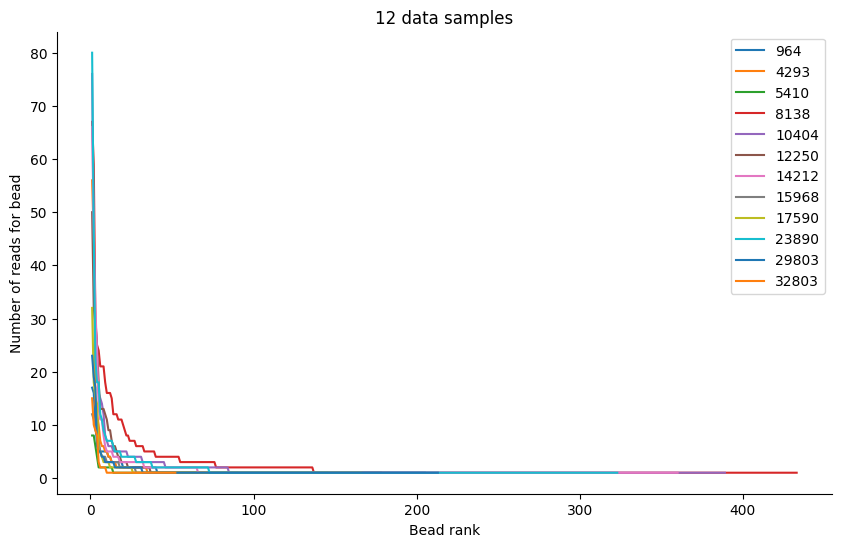

In [11]:
plt.figure(figsize=(10, 6))

# for each groupby of index, plot rank on the x axis and value on the y axis
for name, group in twelve_df.groupby('Index'):
    sns.lineplot(x=group['Rank'], y=group['Value'], label=name)

# Adding title and axis labels
plt.title("12 data samples")
plt.xlabel("Bead rank")
plt.ylabel("Number of reads for bead")

plt.legend()
sns.despine()
plt.show()


In [12]:
def compare_sim_to_data(simulator, df):
    plt.figure(figsize=(15, 12))
    
    # Loop through the groups formed by 'Index'
    for idx, (name, group) in enumerate(df.groupby('Index')):
        
        # Calculate total_read_count for this group
        total_read_count = group['Value'].sum()
        
        # Create a subplot in a 3 x 4 grid
        plt.subplot(3, 4, idx + 1)
        
        # Plot 100 simulation data lines
        for _ in range(100):
            sim_read_counts = simulator(total_read_count)
            sns.lineplot(x=range(1, len(sim_read_counts) + 1), y=sim_read_counts, 
                         label="simulation" if _ == 0 else "", 
                         color='orange', alpha=0.1)
        
        # Plot actual data
        sns.scatterplot(x=group['Rank'], y=group['Value'], label=name, s=100, alpha=0.5)
        
        plt.title(f"Group: {name}")
        plt.xlabel("bead rank")
        plt.ylabel("number of reads for bead")
        
    plt.tight_layout()
    plt.show()

### Inverse square model

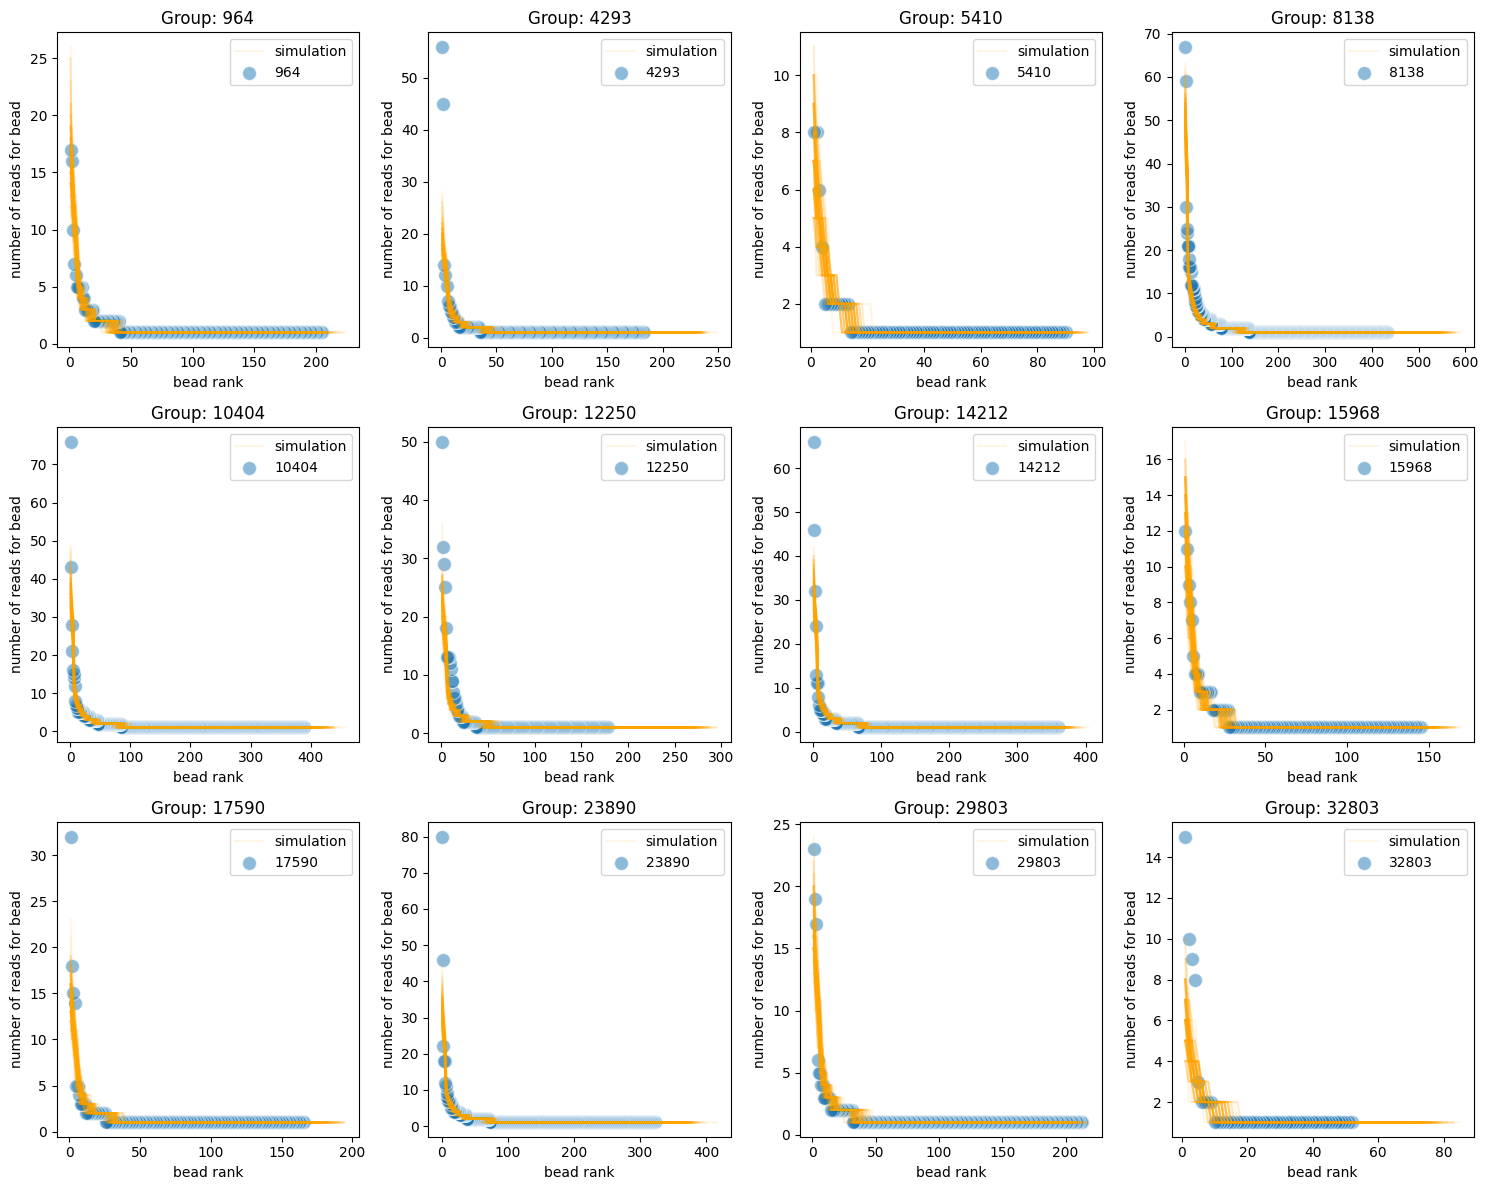

In [13]:
compare_sim_to_data(lambda x: simulate_diffusion(decay_fn_inv_square, our_max_radius, x), twelve_df)

### Rayleigh model

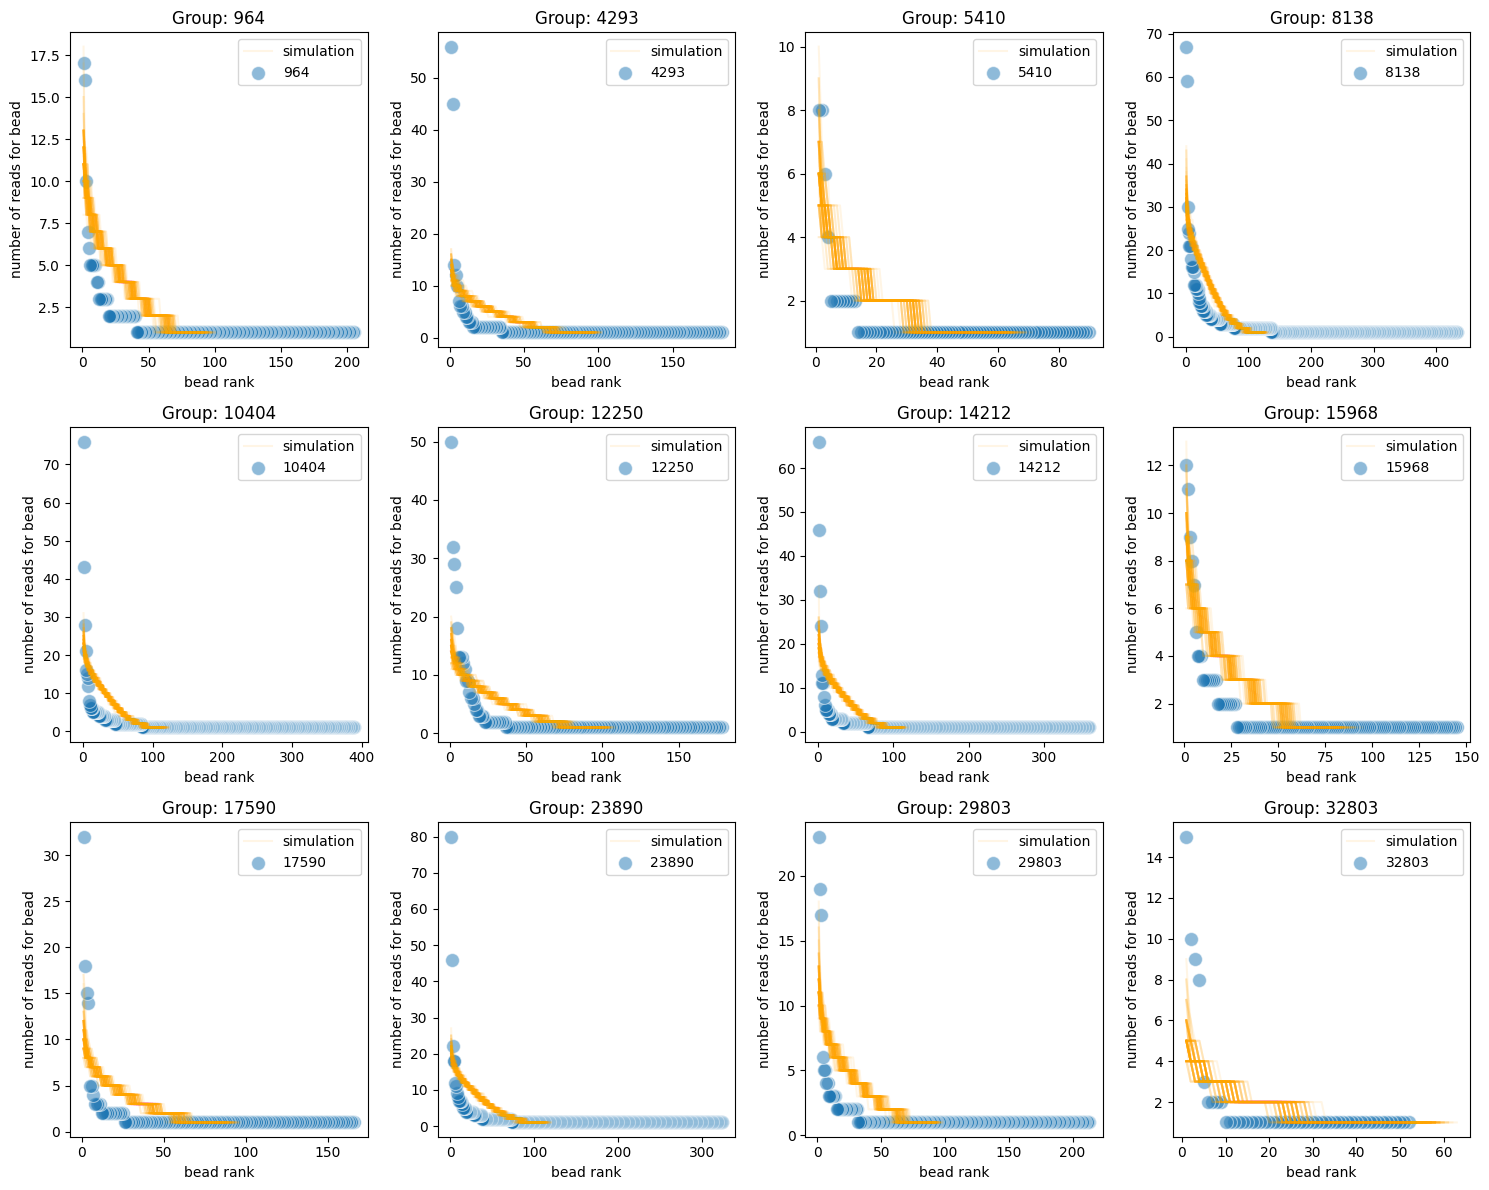

In [14]:
compare_sim_to_data(lambda x: simulate_diffusion(decay_fn_rayleigh, our_max_radius, x), twelve_df)

### What value of max radius makes sense for the inverse square model?

In [15]:
def averaged_simulated_diffusion(decay_fn, max_radius, read_count, replicate_count):
    results_list = []

    for _ in range(replicate_count):
        result = simulate_diffusion(decay_fn, max_radius, read_count)
        results_list.append(result)
    
    max_length = max([len(r) for r in results_list])
    padded_results = [np.pad(r, (0, max_length - len(r))) for r in results_list]
    averaged_result = np.mean(padded_results, axis=0)

    return averaged_result

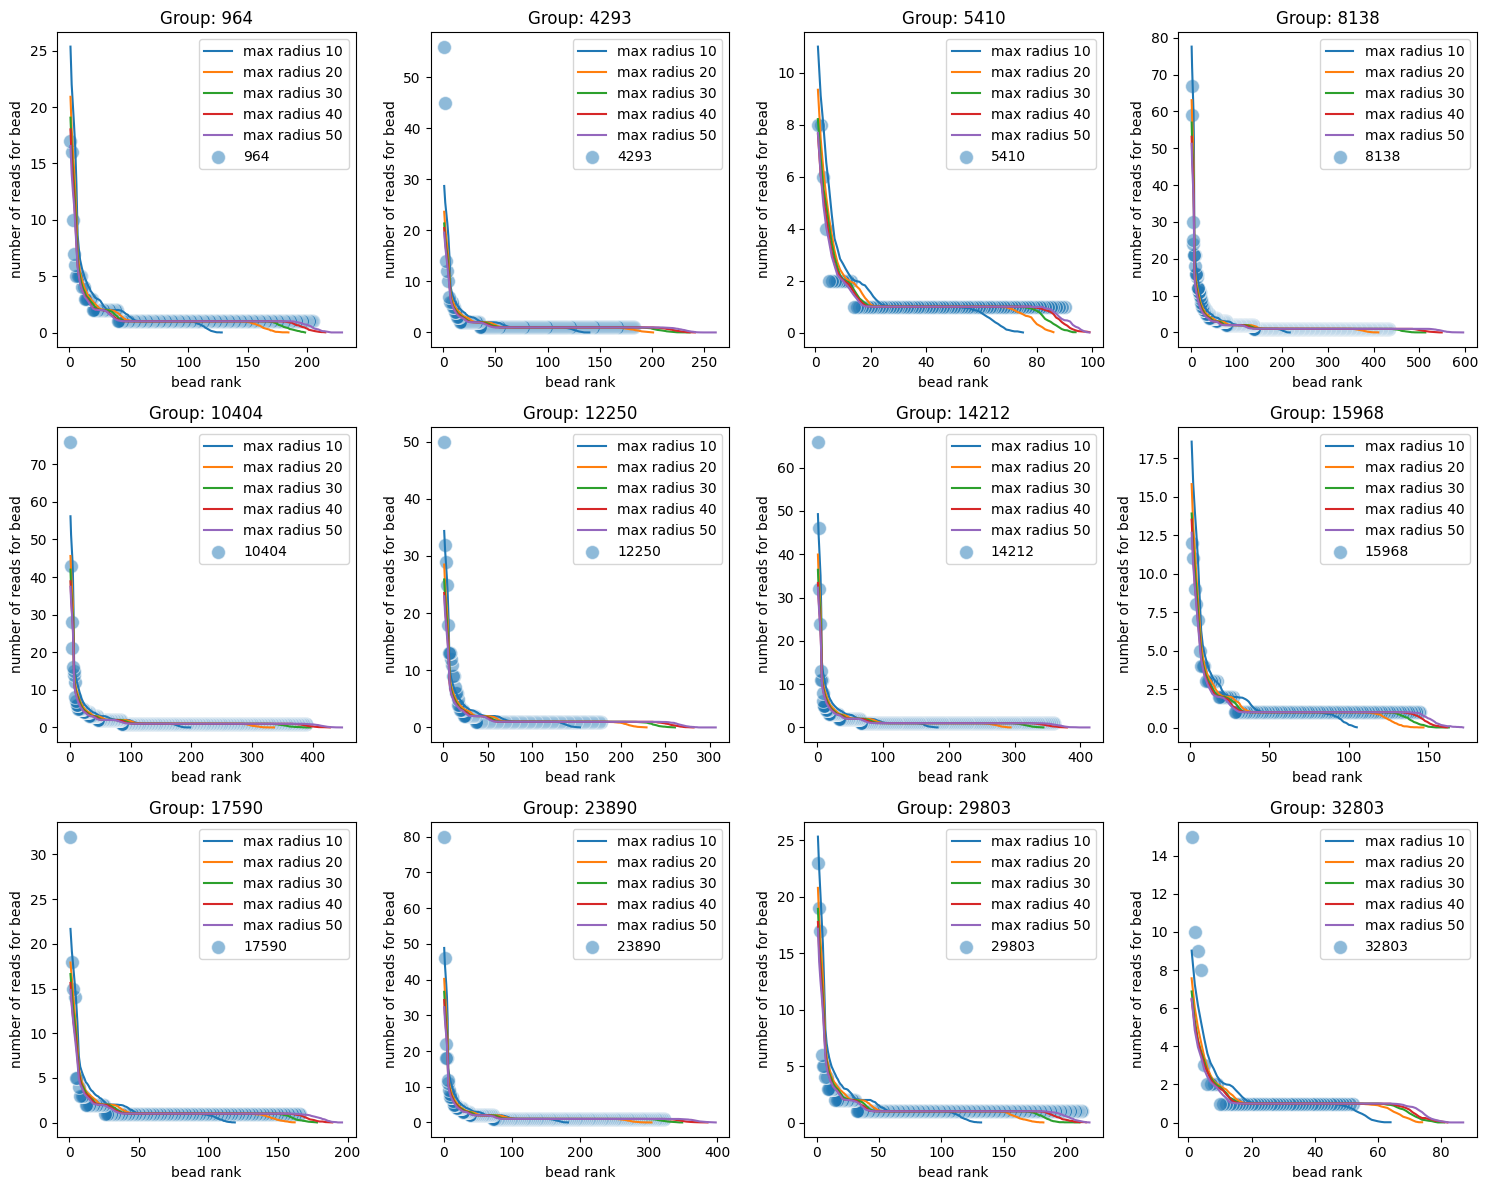

In [16]:
df = twelve_df
our_replicate_count = 100

plt.figure(figsize=(15, 12))

# Loop through the groups formed by 'Index'
for idx, (name, group) in enumerate(df.groupby('Index')):
    
    # Calculate total_read_count for this group
    total_read_count = group['Value'].sum()
    
    # Create a subplot in a 3 x 4 grid
    plt.subplot(3, 4, idx + 1)
    
    # Plot 100 simulation data lines
    for max_radius in [10, 20, 30, 40, 50]:
        sim_read_counts = averaged_simulated_diffusion(decay_fn_inv_square, max_radius, total_read_count, our_replicate_count)
        sns.lineplot(x=range(1, len(sim_read_counts) + 1), y=sim_read_counts, 
                        label=f"max radius {max_radius}")
    
    # Plot actual data
    sns.scatterplot(x=group['Rank'], y=group['Value'], label=name, s=100, alpha=0.5)
    
    plt.title(f"Group: {name}")
    plt.xlabel("bead rank")
    plt.ylabel("number of reads for bead")
    
plt.tight_layout()
plt.show()


In [17]:
simulate_diffusion(decay_fn_inv_square, 50, 1000).shape

(513,)

In [18]:
import numpy as np

def simulate_sticky_walk(delta_r, stickiness, p_outward, sim_count):
    """
    Simulate a "sticky walk" in which an oligo can get stuck or move inward or outward.

    Parameters
    ----------
    delta_r : float
        Step size for each ring.
    stickiness : float
        Probability per unit area of the oligo getting stuck.
    p_outward : float
        Probability of the oligo moving outward when not getting stuck.
    sim_count : int
        Number of simulations to run.

    Returns
    -------
    np.ndarray
        Array of distances where the oligo got stuck in each simulation.
    """
    # Initialize result array
    results = np.zeros(sim_count, dtype=float)

    for i in range(sim_count):
        idx = 1  # Start at the first annulus (innermost circle), index 1

        while True:
            r = idx * delta_r
            area = 2 * np.pi * r * delta_r if idx != 1 else np.pi * r ** 2  # annulus area or circle area
            if np.random.rand() < area * stickiness:
                # Oligo gets stuck
                results[i] = r
                break
            else:
                if idx == 1:
                    # Can only move outward from the innermost circle
                    idx += 1
                else:
                    # Decide whether to move outward or inward
                    if np.random.rand() < p_outward:
                        idx += 1
                    else:
                        idx -= 1
    return results


# Example usage
delta_r = 0.1
stickiness = 0.02
p_outward = 0.2
sim_count = 1000
results = simulate_sticky_walk(delta_r, stickiness, p_outward, sim_count)
pd.Series(results).value_counts().sort_index()

0.1    105
0.2    589
0.3    212
0.4     65
0.5     23
0.6      4
0.7      1
0.8      1
Name: count, dtype: int64

In [19]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import numpy as np

def plot_counts(delta_r, stickiness, p_outward):
    sim_count = 1000
    results = simulate_sticky_walk(delta_r, stickiness, p_outward, sim_count)
    
    unique, counts = np.unique(results, return_counts=True)
    plt.plot(unique, counts)
    
    plt.xlabel("Radius")
    plt.ylabel("Count")
    plt.title("Sticky Walk Simulation")
    plt.show()

# Create widgets for delta_r, stickiness, and p_outward
delta_r_widget = widgets.FloatSlider(value=0.1, min=0.01, max=1.0, step=0.01, description='Delta r:')
stickiness_widget = widgets.FloatSlider(value=0.02, min=0.001, max=0.1, step=0.001, description='Stickiness:')
p_outward_widget = widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.01, description='P Outward:')

# Create interactive plot
interactive_plot = widgets.interactive(
    plot_counts, 
    delta_r=delta_r_widget, 
    stickiness=stickiness_widget, 
    p_outward=p_outward_widget
)

# Display widgets and plot
display(interactive_plot)



interactive(children=(FloatSlider(value=0.1, description='Delta r:', max=1.0, min=0.01, step=0.01), FloatSlide…